In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torchsummary import summary
import torch
import torch.nn as nn
from collections import defaultdict


# dataset
import cv2
from PIL import Image
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import torchvision.utils

#tensorboard
# import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('scalar/NPCC')

import unet_model
import data_process
import loss_func

In [ ]:
train_path1 = '/content/drive/My Drive/Diffuser/201104/220grit_25mm/train'
train_path2 = '/content/drive/My Drive/Diffuser/201104/220grit_50mm/train'
val_path1 = '/content/drive/My Drive/Diffuser/201104/220grit_25mm/val'
val_path2 = '/content/drive/My Drive/Diffuser/201104/220grit_50mm/val'
object_train = '/content/drive/My Drive/Diffuser/gt_calib/train'
object_val = '/content/drive/My Drive/Diffuser/gt_calib/val'
trans1 = Compose([
          transforms.Grayscale(num_output_channels=1),
          ToTensor(),
          # Normalize(mean = [0.5],std = [0.5]),
      ])
trans2 = Compose([
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize(256),
          ToTensor(),
      ])

train_set = ImageDataset2(object_train, [train_path1], trans2)
val_set = ImageDataset2(object_val, [val_path1], trans2)


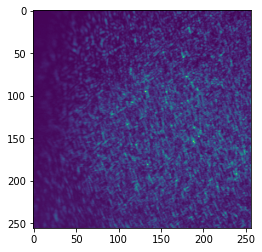

tensor(0.6471) tensor(0.0039) tensor(0.0798) tensor(0.0558)
tensor(1.) tensor(0.) tensor(0.5000) tensor(0.4968)


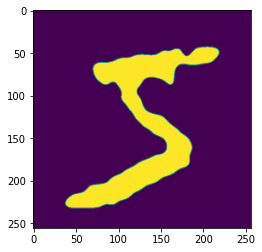

In [ ]:
# check image pairs and data range
A, B = val_set[0]
plt.imshow(A.permute(1,2,0).squeeze())
plt.show()
plt.imshow(B[0].squeeze())
# plt.show()
# plt.imshow(B[1])
for x in (A, B):
    print(x.max(), x.min(), x.mean(), x.std())

In [ ]:
def train_model(model, optimizer, scheduler, num_epochs=20):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
      print('-' * 10) 
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      
      for phase in ['train', 'val']:
        start_time = time.time()
        epoch_samples = 0
        metrics = defaultdict(float)
        
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        for inputs, labels in dataloader[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = calc_loss(outputs, labels, metrics)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
          # add sample size
          epoch_samples += inputs.size(0)
        
        if phase == 'train':
          scheduler.step()
          train_loss.append(metrics['loss']/epoch_samples)
        if phase == 'val':
          val_loss.append(metrics['loss']/epoch_samples)
        
        print_metrics(metrics, epoch_samples, phase)
        print("Iteration time %0.6f" % (time.time() - start_time))
    
    return train_loss, val_loss

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=False, num_workers=0),
    'val': torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False, num_workers=0),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# model = UNet(1).to(device)
model = DenseNet().to(device)

cpu


In [ ]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # %tensorboard --logdir ./content/scalar

# %tensorboard --logdir /content/scalar/NPCC/

In [1]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, momentum= 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

train_model(model, optimizer, exp_lr_scheduler, num_epochs=100)
# writer.close()
torch.save(model.state_dict(), 'test3.pkl')

In [ ]:
t = np.arange(0, num_epochs, 1)
plt.plot(t, train_loss, 'r', val_loss, 'b')
plt.show()

In [ ]:
# evaluate results
model = model.eval()
dataloader_iterator = iter(dataloader['val'])
test_input, test_label = next(dataloader_iterator)
test_input = test_input.to(device)
test_label = test_label.to(device)
test_output = model(test_input)

In [ ]:
fig, axes0 = plt.subplots(1, 3, figsize=(18, 6))
axes0[0].imshow(test_output[0,0].cpu().detach().numpy())
axes0[2].imshow(test_input[0].detach().cpu().squeeze())
axes0[1].imshow(test_label[0,0].detach().cpu())
_, axes1 = plt.subplots(1, 3, figsize=(18, 6))
axes1[0].imshow(test_output[1,0].cpu().detach().numpy())
axes1[2].imshow(test_input[1].detach().cpu().squeeze())
axes1[1].imshow(test_label[1,0].detach().cpu())
_, axes2 = plt.subplots(1, 3, figsize=(18, 6))
axes2[0].imshow(test_output[2,0].cpu().detach().numpy())
axes2[2].imshow(test_input[2].detach().cpu().squeeze())
axes2[1].imshow(test_label[2,0].detach().cpu())
_, axes3 = plt.subplots(1, 3, figsize=(18, 6))
axes3[0].imshow(test_output[3,0].cpu().detach().numpy())
axes3[2].imshow(test_input[3].detach().cpu().squeeze())
axes3[1].imshow(test_label[3,0].detach().cpu())
plt.show()

In [ ]:
_, axes4 = plt.subplots(1, 3, figsize=(18, 6))
axes4[0].imshow(test_output[4,0].cpu().detach().numpy())
axes4[2].imshow(test_input[4].detach().cpu().squeeze())
axes4[1].imshow(test_label[4,0].detach().cpu())
_, axes5 = plt.subplots(1, 3, figsize=(18, 6))
axes5[0].imshow(test_output[5,0].cpu().detach().numpy())
axes5[2].imshow(test_input[5].detach().cpu().squeeze())
axes5[1].imshow(test_label[5,0].detach().cpu())
_, axes6 = plt.subplots(1, 3, figsize=(18, 6))
axes6[0].imshow(test_output[6,0].cpu().detach().numpy())
axes6[2].imshow(test_input[6].detach().cpu().squeeze())
axes6[1].imshow(test_label[6,0].detach().cpu())
_, axes7 = plt.subplots(1, 3, figsize=(18, 6))
axes7[0].imshow(test_output[7,0].cpu().detach().numpy())
axes7[2].imshow(test_input[7].detach().cpu().squeeze())
axes7[1].imshow(test_label[7,0].detach().cpu())
plt.show()